# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp ffp

In [ ]:
#| hide
from nbdev.showdoc import *

In [599]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad, tplquad
from scipy.interpolate import interp1d, interp2d
import pickle
import functools
from pathos.multiprocessing import ProcessingPool as Pool


In [6]:
%load_ext autoreload
%autoreload 2

In [92]:
#| export

# Disk Density
def zthin(r):
    if r > 4.5:
        return zthinSol - (zthinSol - zthin45) * (rsol - r) / (rsol - 4.5)
    else:
        return zthin45

def rho_thin_mw(r, 
             z,
            ) -> float: # FFP density in Msun/kpc^3


    if r > rdBreak:
        result = rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((r - rsol) / rthin)) * (1 / np.cos(np.abs(z) / zthin(r)))**2
    else:
        result = rho_thin_Sol * zthinSol / zthin(r) * \
            np.exp(-((rdBreak - rsol) / rthin)) * (1 / np.cos(np.abs(z) / zthin(r)))**2
    
    return result 

def rho_thick_mw(r, 
              z, 
            ) -> float: # FFP density in Msun/kpc^3
    
    if r > rdBreak:
        result = rho_thick_Sol * np.exp(-((r - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))
    else:
        result = rho_thick_Sol * np.exp(-((rdBreak - rsol) / rthick)) * \
            np.exp(-(np.abs(z) / zthickSol))

    return result 

# Bulge Density
def rsf(xp, yp, zp):
    R = (xp**cperp / x0**cperp + yp**cperp / y0**cperp)**(cpar/cperp) + (zp / z0)**cpar
    return R**(1/cpar)

def fE(xp, yp, zp):
    return np.exp(-rsf(xp, yp, zp))

def cut(x):
    if x > 0:
        return np.exp(-x**2)
    else:
        return 1

def rho_bulge_mw(d: float,
            ) -> float: # FFP density in Msun/kpc^3
    xp, yp = get_primed_coords(d)
    #todo need to generalize this to arbitrary z
    zp = 0
    R = (xp**2 + yp**2 + zp**2)**0.5
    return rho0_B * fE(xp, yp, zp) * cut((R - Rc) / 0.5)

# Total FFP Density
def rho_FFPs_mw(d: float, # distance from Sun in kpc
             ) -> float: # FFP density in Msun/kpc^3
    r = dist_mw(d)
    z = 0
    return (rho_thin_mw(r, z) + rho_thick_mw(r, z) + rho_bulge_mw(d)) 

def m_avg_ffp(m_low, alpha):
    masses = m_low * (1 - np.random.rand(int(1e4)))**(-1 / (alpha - 1))
    masses[masses > m_high_interp] = m_high_interp
    return np.mean(masses)

m_low_ffp_interp = 1e-15
m_high_interp = 1e0
alpha_low_interp = 1
alpha_high_interp = 3

def make_m_avg_interp(n_points=40):
    alpha_arr = np.linspace(alpha_low_interp, alpha_high_interp, n_points)
    m_arr = np.logspace(np.log10(m_low_interp), np.log10(m_high_interp), n_points) #solar masses

    def calc_m_avg_arr(m):
    # Calculate ut_arr for the current m
        return np.array([m_avg_ffp(m, alpha) for alpha in alpha_arr])
    
    with Pool() as p:
        m_avg_values = list(p.map(calc_m_avg_arr, m_arr))

    # Convert ut_values to a 2D array
    m_avg_values = np.array(m_avg_values)
    
    # Create the 2D interpolation table
    m_avg_interp = interp2d(m_arr, alpha_arr, m_avg_values)
    return m_avg_interp

In [168]:
#| export
# Add stellar distribution of M31 following: https://www.aanda.org/articles/aa/pdf/2012/10/aa20065-12.pdf

def einasto(a, rhoc, dn, ac, n):
    return rhoc * np.exp(-dn *((a/ac)**(1/n) - 1))

def rho_bulge_m31(a, 
                ) -> float: # FFP density in Msun/kpc^3
    rhoc = 9.201e-1 * (1e3)**3 #Msun/kpc^3
    dn = 7.769
    ac = 1.155 #kpc
    n = 2.7
    return einasto(a, rhoc, n, ac, dn) 

def rho_disk_m31(a,
                    ) -> float: # FFP density in Msun/kpc^3
    rhoc = 1.307e-2 * (1e3)**3 #Msun/kpc^3
    dn = 3.273
    ac = 10.67 #kpc
    n = 1.2
    return einasto(a, rhoc, n, ac, dn) 

def rho_nucleus_m31(a,
                    ) -> float: # FFP density in Msun/kpc^3
    rhoc = 1.713 * (1e3)**3 #Msun/kpc^3
    dn = 11.668
    ac = 0.0234 #kpc
    n = 4.0
    return einasto(a, rhoc, n, ac, dn) 


def rho_FFPs_m31(a: float, # distance from center of M31 in kpc
             ) -> float: # FFP density in Msun/kpc^3
    return (rho_bulge_m31(a) + rho_disk_m31(a) + rho_nucleus_m31(a))

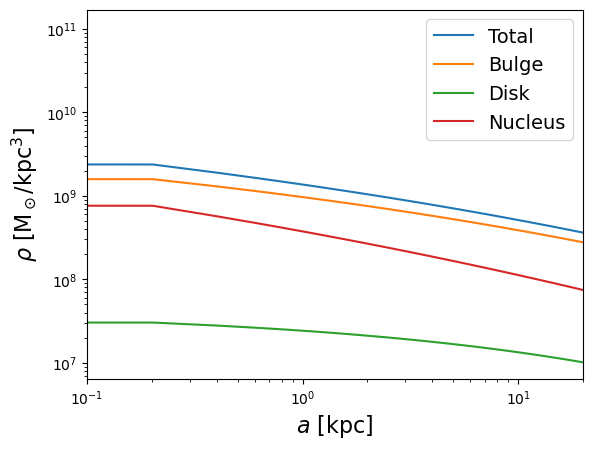

In [169]:
# Define values for the x-axis
a = np.linspace(0, 20, num=100)
z = 0
# Calculate the density values for each component
rho_total_arr = [rho_FFPs_m31(i) for i in a]
rho_bulge_arr = [rho_bulge_m31(i) for i in a]
rho_disk_arr = [rho_disk_m31(i) for i in a]
rho_nucleus_arr = [rho_nucleus_m31(i) for i in a]

# Create the log plot
plt.plot(a, rho_total_arr, label="Total")
plt.plot(a, rho_bulge_arr, label="Bulge")
plt.plot(a, rho_disk_arr, label="Disk")
plt.plot(a, rho_nucleus_arr, label="Nucleus")

# Add labels and legend
plt.xlabel(r"$a$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-1, 20)
# plt.ylim(1e-3, 1e7)

# Show the plot
plt.show()

In [ ]:
#| hide
# m_avg_interp = make_m_avg_interp(n_points=40)
# with open('../interpolations/m_avg_interp.pkl', 'wb') as f:
#     pickle.dump(m_avg_interp, f)

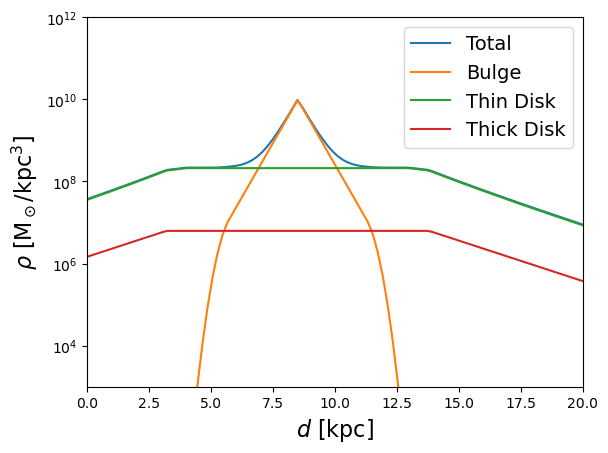

In [172]:
# Define values for the x-axis
d = np.linspace(0, 20, num=100)
z = 0
# Calculate the density values for each component
rho_total_arr = [rho_FFPs_mw(i) for i in d]
rho_bulge_arr = [rho_bulge_mw(i) for i in d]
rho_thin_arr = [rho_thin_mw(dist_mw(i), z) for i in d]
rho_thick_arr = [rho_thick_mw(dist_mw(i), z) for i in d]

# Create the log plot
plt.plot(d, rho_total_arr, label="Total")
plt.plot(d, rho_bulge_arr, label="Bulge")
plt.plot(d, rho_thin_arr, label="Thin Disk")
plt.plot(d, rho_thick_arr, label="Thick Disk")

# Add labels and legend
plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(1e3, 1e12)

# Show the plot
plt.show()


In [711]:
#| export
class Ffp(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                p: float = 2, # Mass function power law index
                ):
        """
        Initialize the PBH population
        """
        
        self.ut_interp = ut_interp
        self.p = p
        #Define range of power law we want to consider
        self.m_min = 1e-15
        self.m_max = 1e-5
        self.Z = self.pl_norm(self.p)

    
    def __str__(self) -> str:
        return f"FFP with power law ~ m^-{self.p}"
    __repr__ = __str__

    def mass_func(self, m):
        #M_norm = 1 solar mass for now
        return (m / 1) ** -self.p
    
    def pl_norm(self, p):
        N_ffp = 1 # Number of FFPs per star
        return N_ffp/abs(nquad(self.mass_func,[[self.m_min, self.m_max]], opts={'points': [self.m_min, self.m_min*1e3]})[0])

    def differential_rate_integrand(self, umin, d, mf, t, dist_func, density_func, v_disp_func, finite=False, density_func_uses_d=False):
        r = dist_func(d)
        ut = self.umin_upper_bound(d, mf) if (self.ut_interp and finite) else 1
        if ut <= umin:
            return 0
        v_rad = velocity_radial(d, mf, umin, t * htosec, ut)  
        v_disp = v_disp_func(r)
        density_input = d if density_func_uses_d else r
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                        #For FFP number density, use stellar density for 1 solar mass stars
                density_func(density_input) / (1 * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                # (mf) ** -self.p)  # mass function
                1)

    # def differential_rate(self, t, integrand_func, finite=False):
    #     if finite:
    #         result, error = tplquad(integrand_func, self.m_min, self.m_max, 
    #                     lambda mf: 0, 
    #                     lambda mf: ds, 
    #                     lambda mf, d: 0, 
    #                     lambda mf, d: self.umin_upper_bound(d, mf), 
    #                     args=(t,))

    #         return result * self.Z    
        
    #     else:
    #         umin_bounds = [0, ut]
    #         d_bounds = [0, ds]
    #         mf_bounds = [self.m_min, self.m_max]
    #         result, error = nquad(integrand_func, [umin_bounds, d_bounds, mf_bounds], args=(t,))
    #         # result, error = tplquad(integrand_func, 
    #         #             self.m_min, self.m_max, 
    #         #             lambda mf: 0, 
    #         #             lambda mf: ds, 
    #         #             lambda mf, d: 0, 
    #         #             lambda mf, d: ut, 
    #         #             args=(t,),)
    #         print(error/result)
    #         return result * self.Z

    def differential_rate(self, t, integrand_func, finite=False):
        num = 20  # number of discretization points
        mf_values = np.logspace(np.log10(self.m_min), np.log10(self.m_max), num=num)
        result = 0
        for i in range(num):
            mf = mf_values[i]
            if i == 0:  # for the first point
                dm = mf_values[i+1] - mf_values[i]
            elif i < num - 1:  # for middle points
                dm = ((mf_values[i+1] - mf_values[i]) + (mf_values[i] - mf_values[i-1])) / 2
            else:  # for the last point
                dm = mf_values[i] - mf_values[i-1]
            #TODO These errors are too big currently. Think about splitting up integral
            if finite:
                single_result, error = dblquad(integrand_func, 
                                            0, ds, 
                                            lambda d: 0, 
                                            lambda d: self.umin_upper_bound(d, mf),
                                            args=(mf, t))
            else:
                single_result, error = dblquad(integrand_func,
                                            0, ds,
                                            lambda d: 0, 
                                            lambda d: ut,
                                            args=(mf, t))
            result += single_result * (mf ** -self.p) * dm  # multiply by mass function and by dm
            # print(error/single_result)
        result *= self.Z  # normalization
        return result
        

    def differential_rate_integrand_mw(self, umin, d, mf, t, finite=False):
        return self.differential_rate_integrand(umin, d, mf, t, dist_mw, rho_FFPs_mw, velocity_dispersion_mw, finite=finite, density_func_uses_d=True)

    def differential_rate_mw(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_mw, finite=finite)

    def differential_rate_integrand_m31(self, umin, d, mf, t, finite=False):
        return self.differential_rate_integrand(umin, d, mf, t, dist_m31, rho_FFPs_m31, velocity_dispersion_m31, finite=finite, density_func_uses_d=False)

    def differential_rate_m31(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_m31, finite=finite)

    def umin_upper_bound(self, d, m):
        if self.ut_interp is None:
            self.make_ut_interp()
        return self.ut_interp(d, m)[0]
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

In [712]:
p = 2
f = Ffp(p)
f

FFP with power law ~ m^-2

In [713]:
#Discretized
print(f.differential_rate(2e2, f.differential_rate_integrand_mw, finite=False))

1.611193720408534e-26


In [729]:
print(f.compute_differential_rate([2e2], finite=False))

[1.7397255169986497e-23]


In [714]:
ts = np.logspace(-8, np.log10(1e3), num=20)
diff_rates = f.compute_differential_rate(ts, finite=False)
diff_rates_finite = f.compute_differential_rate(ts, finite=True)

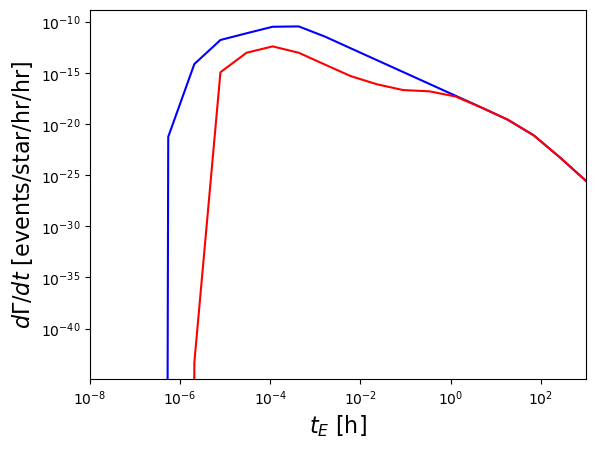

In [716]:
plt.loglog(ts, diff_rates, color="blue")
plt.loglog(ts, diff_rates_finite, color="red")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
# plt.xlim([0.009, 1e3])
# plt.ylim([1e-20, 1e-7])
plt.xlim(min(ts), max(ts))
plt.show()

In [722]:
def crossing_time(m, d):
    #rough crossing time in hours
    return 0.5* (m/1e-8)**(0.5) * (d/100)**0.5


In [726]:
print(scientific_format(crossing_time(1e-15, 100),1))
#So it makes sense the rate is peaked for t~1e-4 hours since that is the crossing time for the smallest mass, which contributes the most

$1.6 \times 10^{-4}$


## Perform Weighted Sum over FFP distribution

In [25]:
#| export
class FfpPopulation():
    
    def __init__(self, 
                 mlow: float, # lower mass limit in solar masses
                 alpha: float, # power law slope of distribution
                 n_bins: int = 10, # number of bins to use for the mass distribution
                 ): 
        if alpha < alpha_low_interp or alpha > alpha_high_interp:
            raise ValueError(f"alpha must be between {alpha_low_interp} and {alpha_high_interp}")
        if mlow < m_low_ffp_interp or mlow > m_high_interp:
            raise ValueError(f"mlow must be between {m_low_ffp_interp} and {m_high_interp}")
        self.mlow = mlow
        self.alpha = alpha
        self.sample_masses = self.generate_sample(int(1e4))
        self.tE_interp = None
        self.tE_finite_interp = None
        self.ut_interp = ut_interp
        self.n_bins = n_bins
        self.ffps = []
        self.ffp_weights = [] #relative contribution of each FFP mass bin

        self.generate_ffps()
    
    def __str__(self):
        return f"FFP: mlow={self.mlow}, alpha={self.alpha}, n_bins={self.n_bins}"
    __repr__ = __str__

    def generate_ffps(self):
        # bins = np.logspace(np.log10(self.mlow), np.log10(np.max(self.sample_masses) * 1.01), num=self.n_bins)
        bins = np.logspace(np.log10(self.mlow), np.log10(self.mlow*1e7) * 1.01, num=self.n_bins)
        counts, hist_bins, = np.histogram(self.sample_masses, bins=bins, density=True)
        bin_centers = (hist_bins[1:] + hist_bins[:-1]) / 2
        weights = counts/np.sum(counts)
        masses = bin_centers
        for mass in masses:
            self.ffps.append(Ffp(mass))
        for weight in weights:
            self.ffp_weights.append(weight)

    def get_weighted_te(self,
                        finite=False,
                        ):
        tMin = 1e-2  # hours
        tMax = 1e3
        n_t_bins = 10
        tBins = np.logspace(np.log10(tMin), np.log10(tMax), num=n_t_bins)

        tETable = np.zeros((len(self.ffps)-1, len(tBins)))
        for i in range(len(self.ffps)-1):
            for j in range(len(tBins)):
                tETable[i,j] = self.ffp_weights[i] * self.ffps[i].differential_rate_total(tBins[j], finite=finite)

        tEWeighted = np.sum(tETable, axis=0)
        return tBins, tEWeighted

    def generate_sample(self, 
                        n: int = int(1e4) # number of samples
                        ):
        masses = self.mlow * (1 - np.random.rand(int(n)))**(-1 / (self.alpha - 1))
        masses[masses > m_high_interp] = m_high_interp
        return masses

    def make_te_interp(self,
                       finite = False,
                       ):
        tBins, tEWeighted = self.get_weighted_te(finite=finite)
        # Handle zero values in tEWeighted
        eps = 1e-50
        tEWeighted_nonzero = np.where(tEWeighted == 0, eps, tEWeighted)
        tEInterp = interp1d(np.log10(tBins), np.log10(tEWeighted_nonzero), kind="cubic")

        if finite:
            self.tE_finite_interp = tEInterp
        else:
            self.tE_interp = tEInterp

    def differential_rate_total(self, t, finite=False):
        if finite:
            if self.tE_finite_interp is None:
                self.make_te_interp(finite=finite)
            return 10**self.tE_finite_interp(np.log10(t))
    
        if self.tE_interp is None:
            self.make_te_interp(finite=finite)
        return 10**self.tE_interp(np.log10(t))

    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

In [26]:
mMin = 1e-12  # solar masses
alpha = 2
fp = FfpPopulation(mMin, alpha)
fp

FFP: mlow=1e-12, alpha=2, n_bins=10

In [32]:
fp2 = FfpPopulation(mMin, 1.1)

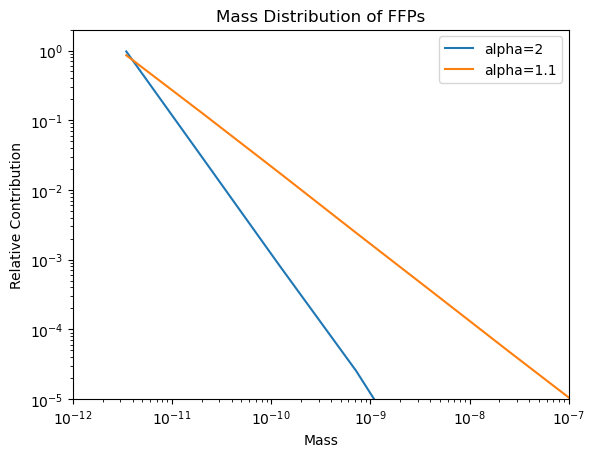

In [33]:
plt.loglog([ffp.mass for ffp in fp.ffps], fp.ffp_weights, label="alpha=2")
plt.loglog([ffp.mass for ffp in fp2.ffps], fp2.ffp_weights, label="alpha=1.1")
plt.xlabel("Mass")
plt.ylabel("Relative Contribution")
plt.title("Mass Distribution of FFPs")
plt.xlim(1e-12, 1e-7)
plt.ylim(1e-5, 2e0)
plt.legend()
plt.show()

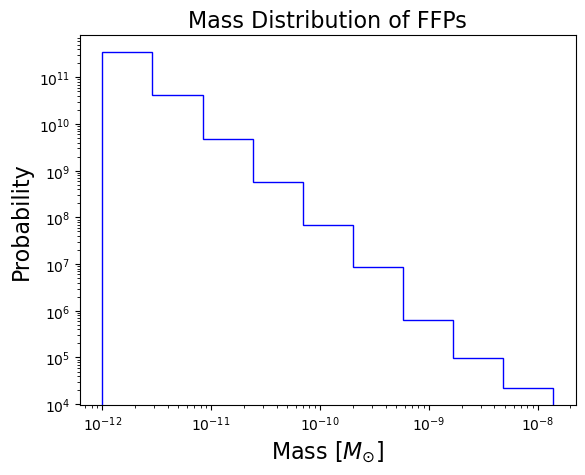

In [ ]:
nBins = 10
tMin = 1e-2  # hours
tMax = 1e3
ntBins = 10

fp.generate_sample(n=1e4)
mSample = fp.sample_masses
tBins = np.logspace(np.log10(tMin), np.log10(tMax), num=ntBins)
bins = np.logspace(np.log10(mMin), np.log10(np.max(mSample) * 1.01), num=nBins)
hist, bins = np.histogram(mSample, bins=bins, density=True)

plt.hist(mSample, bins=bins, density=True, histtype="step", color="blue")

plt.xlabel("Mass [$M_{\odot}$]", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.title("Mass Distribution of FFPs", fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
ts = np.logspace(-2, np.log10(1e3), num=100)
diff_rates = fp.compute_differential_rate(ts, finite=False)
diff_rates_finite = fp.compute_differential_rate(ts, finite=True)

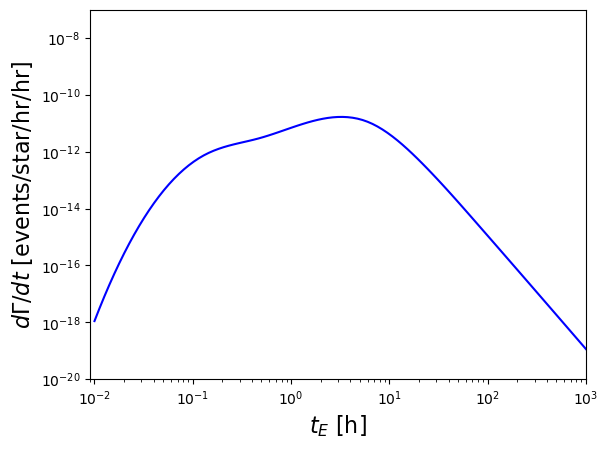

In [ ]:
#this is with m31 contribution
ts = np.logspace(-2, np.log10(1e3), num=100)
diff_rates = fp.compute_differential_rate(ts, finite=False)

plt.loglog(ts, diff_rates, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

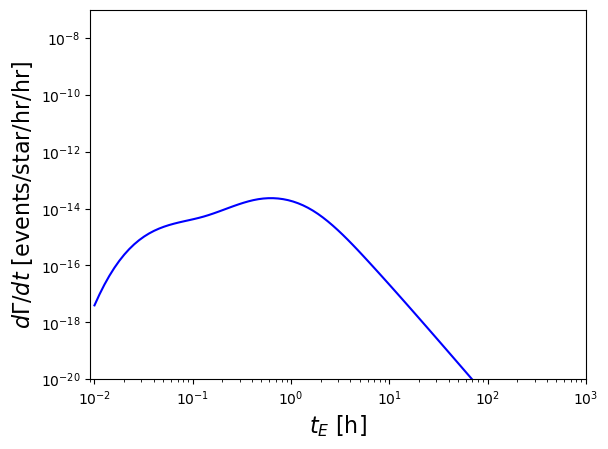

In [ ]:
#this is just mw
ts = np.logspace(-2, np.log10(1e3), num=100)
diff_rates = fp.compute_differential_rate(ts, finite=False)

plt.loglog(ts, diff_rates, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

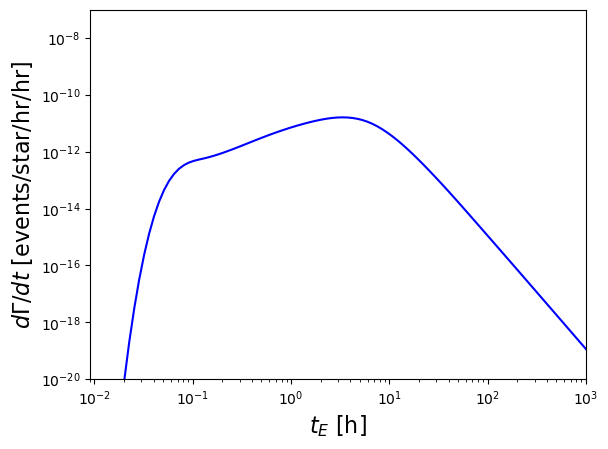

In [ ]:
#This is with m31 contribution
diff_rates_finite = fp.compute_differential_rate(ts, finite=True)
plt.loglog(ts, diff_rates_finite, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

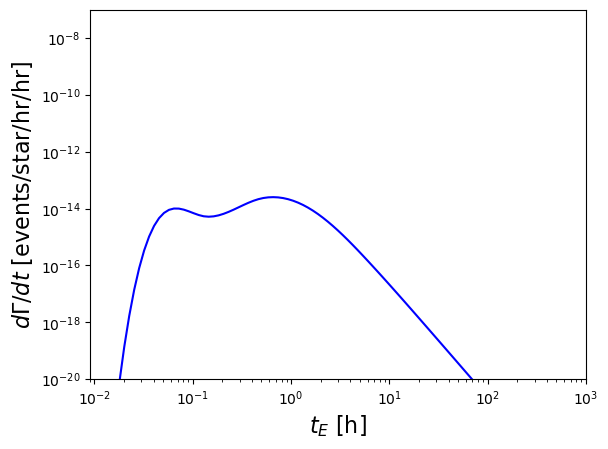

In [ ]:
#this is just mw
diff_rates_finite = fp.compute_differential_rate(ts, finite=True)
plt.loglog(ts, diff_rates_finite, color="blue")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.xlim([0.009, 1e3])
plt.ylim([1e-20, 1e-7])
plt.show()

## Reworking the mass distribution of FFPs

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()